### Trying to understand condition-specific regulator clusters
#### (1) Is it because regulators or downstream genes are only expressed in one/some conditions?
#### (2) Is this mainly a quantitative effect: quantitative change in expression alters power and/or regulatory connections become stronger

In [13]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

In [7]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)

In [9]:
adata_final = sc.read_h5ad(datadir + f'/DE_results_all_confounders/nde50ntotal100_clustering.h5ad')

In [21]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
de_summary_stats.baseMean = de_summary_stats.baseMean.fillna(0)

In [10]:
adata_final

AnnData object with n_obs × n_vars = 1867 × 9779
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hierarchical', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [11]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.target_contrast_gene_name.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

### First identify condition-specific clusters

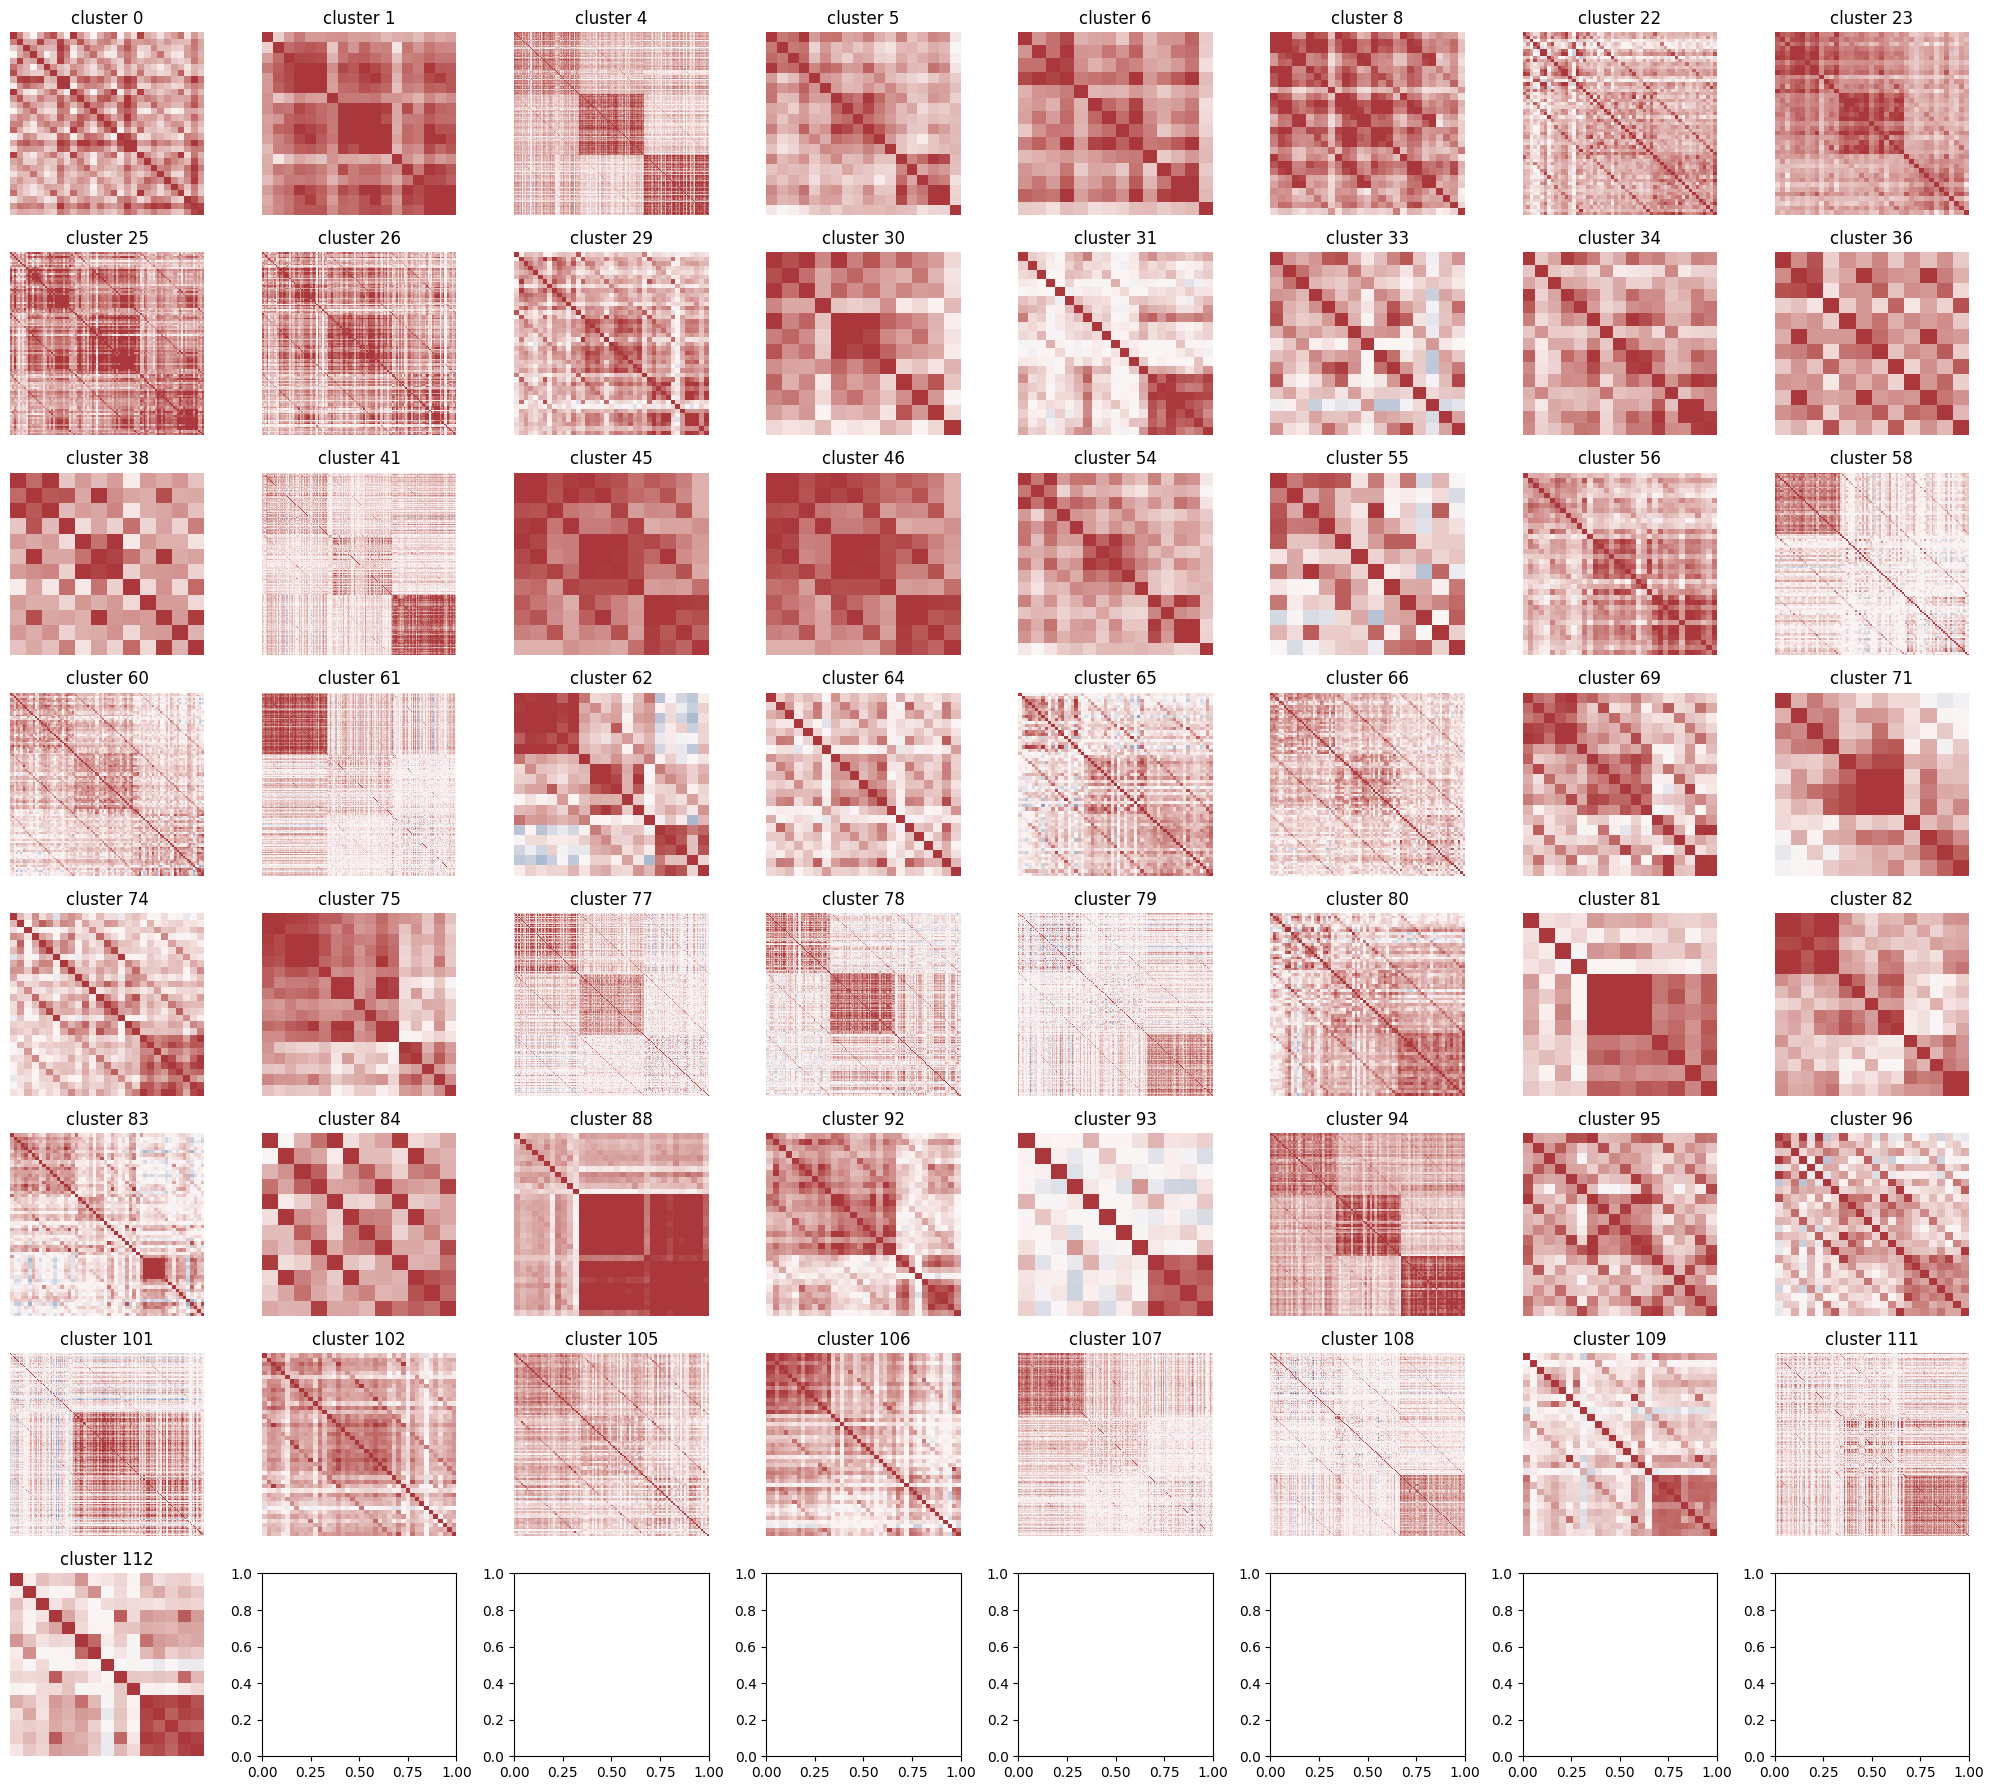

In [14]:
fig, axes = plt.subplots(8,8,figsize=(20,18))
ax = axes.flatten()
cluster_list = np.sort(adata_final.obs.hdbscan.unique())
for i in range(57):
    genelist = adata_final[adata_final.obs.hdbscan==cluster_list[i]].obs.target_contrast_gene_name_corrected.unique().tolist()
    corr_mtx = corr_compute(adata_de, genelist)
    sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', ax=ax[i], xticklabels=[], yticklabels=[], cbar=False)
    ax[i].set_title('cluster '+str(cluster_list[i]))
plt.tight_layout()

In [15]:
stim48hr_specific_cluster = [31, 93, 108, 109, 111, 112]
rest_specific_cluster = [58, 61, 106, 107]

### First check gene expression

In [18]:
cluster_list

array([  0,   1,   4,   5,   6,   8,  22,  23,  25,  26,  29,  30,  31,
        33,  34,  36,  38,  41,  45,  46,  54,  55,  56,  58,  60,  61,
        62,  64,  65,  66,  69,  71,  74,  75,  77,  78,  79,  80,  81,
        82,  83,  84,  88,  92,  93,  94,  95,  96, 101, 102, 105, 106,
       107, 108, 109, 111, 112])

In [46]:
genelist = adata_final[adata_final.obs.hdbscan==108].obs.target_contrast_gene_name_corrected.unique().tolist()
data = {'Rest': de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Rest')].baseMean.tolist(), 
        'Stim8hr': de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim8hr')].baseMean.tolist(),
        'Stim48hr': de_summary_stats[(de_summary_stats.target_name.isin(genelist))&(de_summary_stats.condition=='Stim48hr')].baseMean.tolist()}

long_format_data = []
for condition, base_means in data.items():
    for base_mean in base_means:
        long_format_data.append({'condition': condition, 'baseMean': base_mean})

df = pd.DataFrame(long_format_data)

<Axes: xlabel='condition', ylabel='baseMean'>

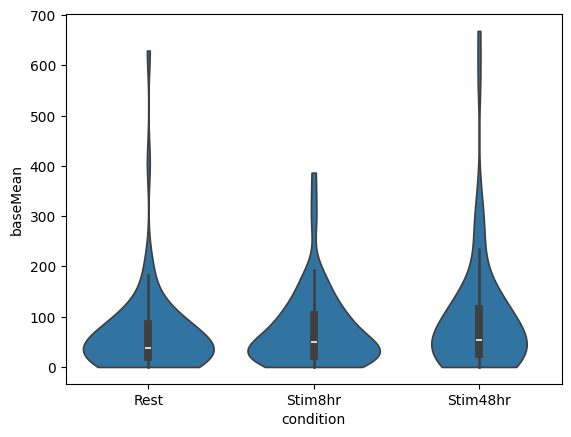

In [47]:
sns.violinplot(df, x='condition', y='baseMean', cut=0, )

In [32]:
df

,condition,baseMean
0,Rest,83.010090
1,Rest,65.809531
2,Rest,21.998599
3,Rest,1.803009
4,Rest,30.221794
5,Rest,27.853926
6,Rest,69.305795
7,Stim8hr,2.596873
8,Stim8hr,75.611796
9,Stim8hr,46.984122
